# SynthMorph PyTorch Demo

## Purpose
Reproduce the original SynthMorph demo in Torch.
- Data generation
- Registration model training
- Registration (inference) examples  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import urllib.request
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np 
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import pytorch_lightning as pl

# local code
from synthmorph import models, datamodule as dm, utils

device = 'cuda' if torch.cuda.is_available() else 'cpu'     # note: only gpu has been tested so far

## Synthetic Images
Currrently still using NumPy code to generate synthetic labels and images, Torch implementation is still WIP.

### Generate Label (i.e. Segmentation) Map
Generating labels in NumPy is slow

In [3]:
# Input shapes.
in_shape = (256,) * 2
num_dim = len(in_shape)
num_label = 16

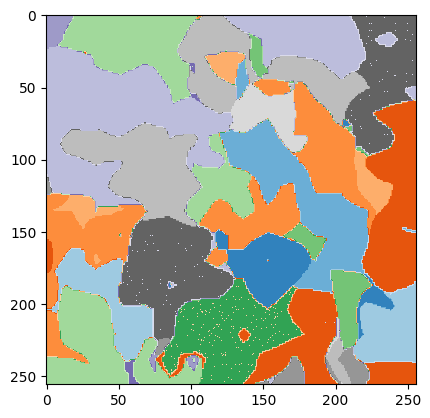

In [4]:
label_map = dm.generate_map(in_shape, num_label)
plt.imshow(label_map, cmap='tab20c')

### Generate Image from Label Map

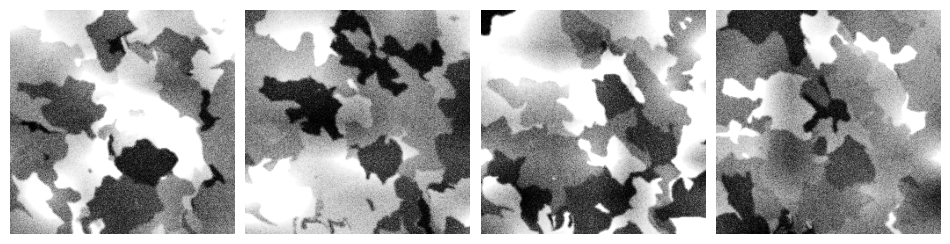

In [5]:
n = 4
gen_images = [dm.map_to_image(label_map) for _ in range (n)]

# Set up the subplot layout
fig, axes = plt.subplots(1, n, figsize=(n*3, 3))

# Iterate over the images and plot them in the subplots
for i in range(n):
    axes[i].imshow(gen_images[i][1], cmap='gray')
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05)

# Display the plots
plt.show()


In [6]:
# Warning: One label map takes a few seconds to generate
# WIP to use Torch instead of NumPy for label map  generation
size= 40
in_shape = (256,) * 2
num_labels = 16
train_data = dm.SynthMorphDataset(
    size=size,
    input_size=in_shape,
    num_labels=num_labels,
)

dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,
    num_workers=8,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 40/40 [03:07<00:00,  4.68s/it]


## Model Training

In [80]:
# You can generate the Torch version of the original author's weights from tf2torch.ipynb
# State_dict weights for the registration model, different from PL checkpoint
reg_weights = Path(".") / "torch_weights.pth"   # 'None' for no weight loading
# Fresh model
in_shape = (256,) * 2
unet_enc_nf = [256] * 4
unet_dec_nf = [256] * 8
model = models.SynthMorph(
    vol_size=in_shape,
    num_labels=train_data.num_labels,
    enc_nf=unet_enc_nf,
    dec_nf=unet_dec_nf,
    lmd=1,
    reg_weights=reg_weights
)
n_param = utils.torch_model_parameters(model.reg_model)

+------------------------------------+-----------+
|               Module               | Parameter |
+------------------------------------+-----------+
| unet_model.encoder.0.0.main.weight |    4608   |
|  unet_model.encoder.0.0.main.bias  |    256    |
| unet_model.encoder.1.0.main.weight |   589824  |
|  unet_model.encoder.1.0.main.bias  |    256    |
| unet_model.encoder.2.0.main.weight |   589824  |
|  unet_model.encoder.2.0.main.bias  |    256    |
| unet_model.encoder.3.0.main.weight |   589824  |
|  unet_model.encoder.3.0.main.bias  |    256    |
| unet_model.decoder.0.0.main.weight |   589824  |
|  unet_model.decoder.0.0.main.bias  |    256    |
| unet_model.decoder.1.0.main.weight |  1179648  |
|  unet_model.decoder.1.0.main.bias  |    256    |
| unet_model.decoder.2.0.main.weight |  1179648  |
|  unet_model.decoder.2.0.main.bias  |    256    |
| unet_model.decoder.3.0.main.weight |  1179648  |
|  unet_model.decoder.3.0.main.bias  |    256    |
| unet_model.remaining.0.main.w

In [8]:
# # Model from checkpoint
# checkpoint_path = './lightning_logs/version_67/checkpoints/epoch=9999-step=400000.ckpt'
# in_shape = (256,) * 2
# unet_enc_nf = [256] * 4
# unet_dec_nf = [256] * 8
# model = model.load_from_checkpoint(
#     checkpoint_path, 
#     vol_size=in_shape,
#     num_labels=train_data.num_labels,
#     enc_nf=unet_enc_nf,
#     dec_nf=unet_dec_nf,
#     lmd=1, 
# )

In [9]:
max_epochs = 100
steps = train_data.size
max_steps = max_epochs * steps
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=max_epochs,
    max_steps=max_steps,
    log_every_n_steps=steps
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model=model, train_dataloaders=dataloader)

2023-10-27 18:56:14.835856: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-27 18:56:14.882320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | reg_model | VxmDense | 8.3 M 
---------------------------------------
8.3 M     Trainable params
0         Non-trainable params
8.3 M     Total params
33.079    Total estimated model params size (MB)


Training: |                                                                                              | 0/?…

`Trainer.fit` stopped: `max_steps=4000` reached.


## Model  Evaluation

In [11]:
# # Model from best checkpoint
# checkpoint_path = './lightning_logs/version_64/checkpoints/epoch=4999-step=200000.ckpt'
# in_shape = (256,) * 2
# unet_enc_nf = [256] * 4
# unet_dec_nf = [256] * 8
# model = model.load_from_checkpoint(
#     checkpoint_path, 
#     vol_size=in_shape,
#     num_labels=16,
#     enc_nf=unet_enc_nf,
#     dec_nf=unet_dec_nf,
#     lmd=1, 
# )

In [48]:
model = model.cuda()   # temporary fix
model = model.eval()

### MNIST

In [13]:
mnist = MNIST(root= "./data", train=False, download=True)

In [14]:
images = np.array(mnist.data)
labels = np.array(mnist.targets)
indices = np.arange(len(labels))
# Dictionary of indices based on target labels
label_indices_dict = {}
unique_labels = np.unique(labels)
for label in unique_labels:
    label_indices_dict[label] = np.where(labels == label)[0].tolist()

In [49]:
# Example prediction
in_shape = (256,) * 2
digit = 4
indices = label_indices_dict[digit]
ori_moving = images[indices[6]]
ori_fixed = images[indices[9]]
moving = dm.conform(x=ori_moving, in_shape=in_shape, device=device)
fixed = dm.conform(x=ori_fixed, in_shape=in_shape, device=device)
moved, warp = model.predict_step(moving, fixed)
moved, warp = dm.post_predict(moved), dm.post_predict(warp)
moving, fixed = moving.detach().cpu().numpy(), fixed.detach().cpu().numpy()
moving, fixed = np.squeeze(moving), np.squeeze(fixed)

<class 'numpy.ndarray'>


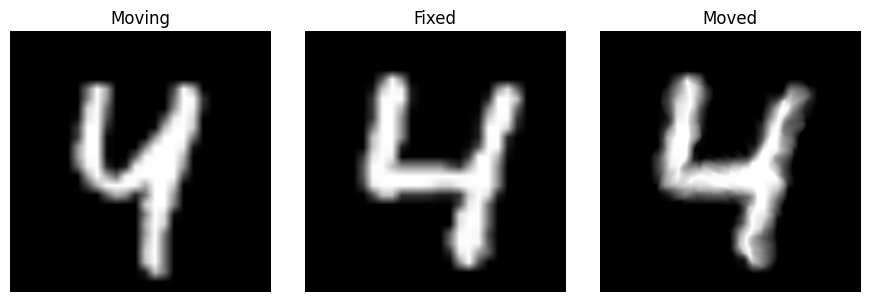

In [50]:
movement_plot = [moving, fixed, moved]
print(type(moved))
movement_headers = ['Moving', 'Fixed', 'Moved']
utils.plot_array_row(movement_plot, movement_headers, cmap='gray')

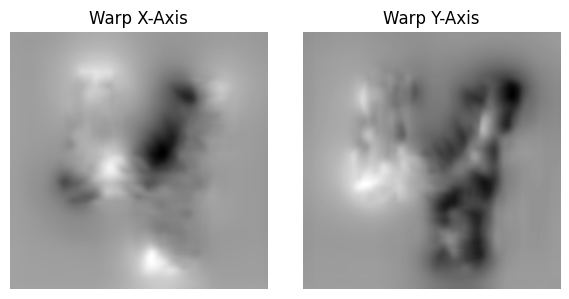

In [51]:
warp_plot = [warp[0, ...], warp[1, ...]]
warp_headers=['Warp X-Axis', 'Warp Y-Axis']
utils.plot_array_row(warp_plot, warp_headers, cmap='gray')

### Oasis-1 2D (Brain dataset)

In [52]:
oasis_path = Path.home() / "oasis_2d"
oasis_path.mkdir(exist_ok=True)
filename = oasis_path / '2D-OASIS-TUTORIAL.npz'
if not filename.exists():
    url = 'https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/2D-OASIS-TUTORIAL.npz'
    urllib.request.urlretrieve(url, filename)
oasis_data = np.load(filename)['images']


In [53]:
in_shape = (256,) * 2
ori_moving = oasis_data[2]
ori_fixed = oasis_data[7]
moving = dm.conform(x=ori_moving, in_shape=in_shape, device=device)
fixed = dm.conform(x=ori_fixed, in_shape=in_shape, device=device)
moved, warp = model.predict_step(moving, fixed)
moved, warp = dm.post_predict(moved), dm.post_predict(warp)
moving, fixed = moving.detach().cpu().numpy(), fixed.detach().cpu().numpy()
moving, fixed = np.squeeze(moving), np.squeeze(fixed)

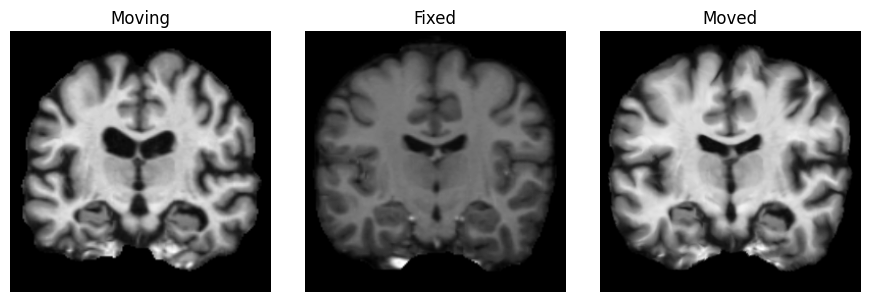

In [54]:
movement_plot = [moving, fixed, moved]
movement_headers = ['Moving', 'Fixed', 'Moved']
utils.plot_array_row(movement_plot, movement_headers, cmap='gray')

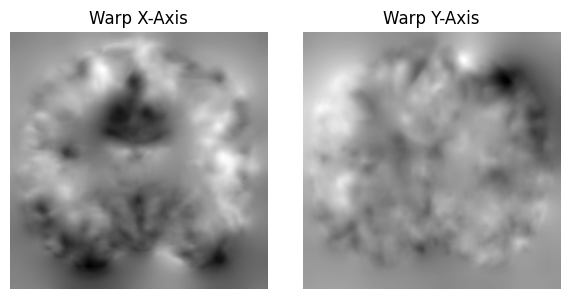

In [56]:
warp_plot = [warp[0, ...], warp[1, ...]]
warp_headers=['Warp X-Axis', 'Warp Y-Axis']
utils.plot_array_row(warp_plot, warp_headers, cmap='gray')

### Affine registration test
Evaluates registration for the following properties of target shapes:
- Size (scaling)
- Coordinates (translation, rotation)

#### Superimposed circles on synthetic image
Note: The label map is only used to create synthetic images which serve as background, only the circles are considered labels (i.e. target shapes)

In [67]:
# Label generation
in_shape = (256,) * 2
num_dim = len(in_shape)
num_label = 16
label_map = dm.generate_map(in_shape, num_label)

In [70]:
# Image generation
ori_image = np.squeeze(dm.map_to_image(label_map)[1])
image = ori_image.copy()


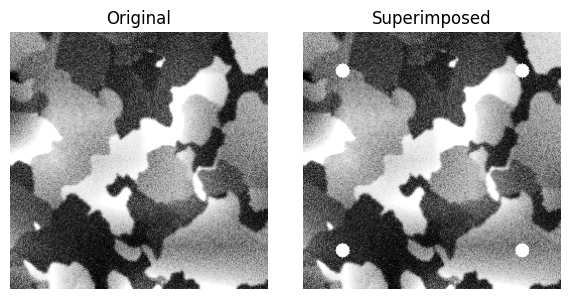

In [71]:
# Example of superimposing circles on image
pixel_value = 255
size_range = (0.030, 0.030)
dist_range = (70, 71)
rotate = 0
x_shift = 0
y_shift = 0
superimposed = utils.superimpose_circles(
    image, 
    pixel_value, 
    size_range, 
    dist_range, 
    rotate,
    x_shift,
    y_shift,
)

superimposed_array = [ori_image, superimposed]
superimposed_headers = ['Original', 'Superimposed']
utils.plot_array_row(superimposed_array, superimposed_headers, cmap='gray')

In [74]:
# Create random image-mask pairs for moving and fixed
moving_superimpose = lambda moving: utils.superimpose_circles(
    moving, 
    pixel_value=255, 
    size_range=(0.030, 0.030), 
    dist_range=(70, 71), 
    rotate=0,
    x_shift=0,
    y_shift=0,
)
moving= moving_superimpose(np.squeeze(dm.map_to_image(label_map)[1]))

fixed_superimpose = lambda fixed: utils.superimpose_circles(
    fixed, 
    pixel_value=255, 
    size_range=(0.025, 0.035), 
    dist_range=(65, 75), 
    rotate=0,
    x_shift=3,
    y_shift=3,
)
zeros = np.zeros(shape=(256, 256), dtype=np.float32)
fixed_mask = fixed_superimpose(zeros)
fixed = fixed_superimpose(np.squeeze(dm.map_to_image(label_map)[1]))



moving = dm.conform(x=moving, in_shape=in_shape, device=device)
fixed = dm.conform(x=fixed, in_shape=in_shape, device=device)

moved, warp = model.predict_step(moving, fixed)
moved, warp = dm.post_predict(moved), dm.post_predict(warp)
# post-process for plotting
moving, fixed = moving.detach().cpu().numpy(), fixed.detach().cpu().numpy()
moving, fixed = np.squeeze(moving), np.squeeze(fixed)  

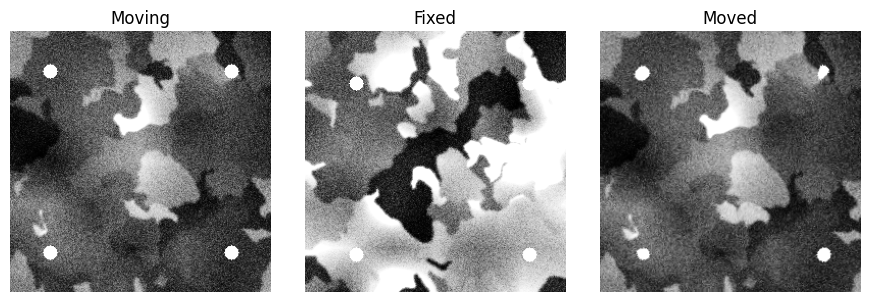

In [75]:
movement_plot = [moving, fixed, moved]
movement_headers = ['Moving', 'Fixed', 'Moved']
utils.plot_array_row(movement_plot, movement_headers, cmap='gray')

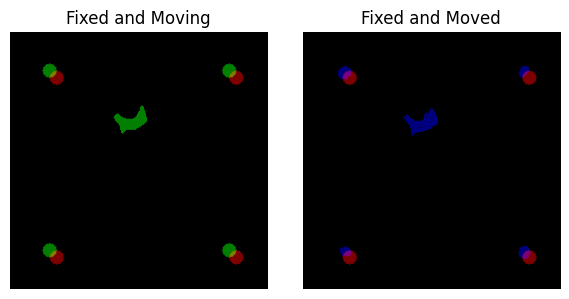

In [76]:
# The labels here are supposed to be the circles only,
#  ignore areas which share the same value
rgb_fixed = utils.convert_to_single_rgb(fixed_mask, 'red')
rgb_moving = utils.convert_to_single_rgb(moving, 'green')
rgb_moved = utils.convert_to_single_rgb(moved, 'blue')

overlay_before = utils.overlay_images(rgb_fixed, rgb_moving)
overlay_after = utils.overlay_images(rgb_fixed, rgb_moved)

overlay_plot = [overlay_before, overlay_after,]
overlay_headers = ['Fixed and Moving', 'Fixed and Moved']
utils.plot_array_row(overlay_plot, overlay_headers, cmap=None)

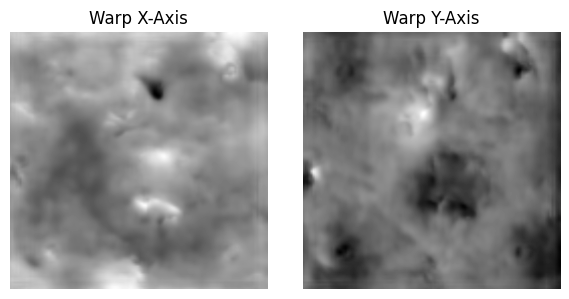

In [77]:
warp_plot = [warp[0, ...], warp[1, ...]]
warp_headers=['Warp X-Axis', 'Warp Y-Axis']
utils.plot_array_row(warp_plot, warp_headers, cmap='gray')